## Import of modules

In this notebook for layered graph hierarchical clustering based on tropical algebra we use the following modules of python in order to represent the object we need.

In [1]:
#Import all the necessary libraries
import pandas as pd
import numpy as np
import scipy
import matplotlib
import sklearn #importing scikit-learn library
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import networkx as nx
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist, squareform


## Light Preprocessing

Firstly we will do light pre-processing meaning we will just squeez out the missing values and we will not attempt to generate transition data for missing values (which in real life is a more favorable situation depending on the difficulty to acquire data first hand). This light pre-processing is meaning full for our studies as we want to preserve categorical data as much as possible.

In [2]:
#Load the data & summary checkup
df = pd.read_csv(r"C:/Users/guera/Documents/Python Scripts/Research_Mixed_Data_Hierarchical_Clustering/iris.csv") # iris 3, penguins 3 or titanic 2
n_cluster_opt = 3
print(df.head(), '\n')
df.isna().sum()

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa 



Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [3]:
# Drop rows with missing values
df = df.dropna() 
df = df.reset_index(drop=True)  # Reset the index after dropping rows   
df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [4]:
print(list(df.columns))

['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']


Let's just clean the type of data we are facing : 

In [5]:
# data type modification IRIS
df['Id']               = df['Id'].astype('int64')
df['SepalLengthCm']    = df['SepalLengthCm'].astype('float64')
df['SepalWidthCm']     = df['SepalWidthCm'].astype('float64')
df['PetalLengthCm']    = df['PetalLengthCm'].astype('float64')
df['PetalWidthCm']     = df['PetalWidthCm'].astype('float64')
df['Species']          = df['Species'].astype('category')
categorical_columns = ['Species']
numerical_columns = ['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

## data type modification PENGUINS
#df['species'] = df['species'].astype('category')
#df['island'] = df['island'].astype('category')
#df['bill_length_mm'] = df['bill_length_mm'].astype('float64')
#df['bill_depth_mm'] = df['bill_depth_mm'].astype('float64')
#df['flipper_length_mm'] = df['flipper_length_mm'].astype('float64')
#df['body_mass_g'] = df['body_mass_g'].astype('float64')
#df['sex'] = df['sex'].astype('category')
#df['year'] = df['year'].astype('int64')
#categorical_columns = ['species', 'island', 'sex']
#numerical_columns = ["bill_length_mm", "flipper_length_mm", "body_mass_g", "flipper_length_mm"]

## data type modification TITANIC
#numerical_columns = ['PassengerId','Survived','Pclass','Age','SibSp','Parch','Fare']
#categorical_columns = ['Name','Sex','Ticket','Embarked']  # Cabin removed
#df[numerical_columns] = df[numerical_columns].astype({
#    'PassengerId':'int64',
#    'Survived':'int64',
#    'Pclass':'int64',
#    'Age':'float64',
#    'SibSp':'int64',
#    'Parch':'int64',
#    'Fare':'float64'
#})
#df[categorical_columns] = df[categorical_columns].astype('category')

# Print data types of each column
for column in df.columns:
    print(f"Column {column}: {df[column].dtype}")

Column Id: int64
Column SepalLengthCm: float64
Column SepalWidthCm: float64
Column PetalLengthCm: float64
Column PetalWidthCm: float64
Column Species: category


In [6]:
# Encode categorical columns
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
print(df.head(), '\n')

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  Species
0   1            5.1           3.5            1.4           0.2        0
1   2            4.9           3.0            1.4           0.2        0
2   3            4.7           3.2            1.3           0.2        0
3   4            4.6           3.1            1.5           0.2        0
4   5            5.0           3.6            1.4           0.2        0 



Let's Normalize our data in order to have smooth process later on :

In [7]:
#Normalization des données

# Select columns to normalize
columns_to_normalize = [col for col in numerical_columns]

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the selected columns
scaler.fit(df[columns_to_normalize])

# Transform the selected columns using the scaler
df[columns_to_normalize] = scaler.transform(df[columns_to_normalize])

# Print the normalized dataframe
print(df)

           Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
0   -1.720542      -0.900681      1.032057      -1.341272     -1.312977   
1   -1.697448      -1.143017     -0.124958      -1.341272     -1.312977   
2   -1.674353      -1.385353      0.337848      -1.398138     -1.312977   
3   -1.651258      -1.506521      0.106445      -1.284407     -1.312977   
4   -1.628164      -1.021849      1.263460      -1.341272     -1.312977   
..        ...            ...           ...            ...           ...   
145  1.628164       1.038005     -0.124958       0.819624      1.447956   
146  1.651258       0.553333     -1.281972       0.705893      0.922064   
147  1.674353       0.795669     -0.124958       0.819624      1.053537   
148  1.697448       0.432165      0.800654       0.933356      1.447956   
149  1.720542       0.068662     -0.124958       0.762759      0.790591   

     Species  
0          0  
1          0  
2          0  
3          0  
4          0  
..       

## Layered Numerical Graph based on euclidian distance

As the euclidian distance is only relevant for numerical data, we adapt our code to our problem and use 4 labels ; bill_length_mm	bill_depth_mm	flipper_length_mm	body_mass_g in order to compute 4 differents graph with vertices representing each line and edges representing the euclidian distance (relevant to compare such numerical data type).

In [8]:
from itertools import combinations

# Function to calculate Euclidean distance between penguins based on selected features
def calculate_distance(p1, p2, features):
    distance = np.sqrt(sum((p1[feat] - p2[feat]) ** 2 for feat in features))
    return distance

# Function to create graph
def create_graph(features):
    # Create an undirected graph
    G = nx.Graph()

    # Add vertices to the graph
    for i, _ in df.iterrows():
        G.add_node(i, label=f'Line {i}')

    # Add edges with Euclidean distances as weights
    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            weight = calculate_distance(df.iloc[i], df.iloc[j], features)
            G.add_edge(i, j, weight=weight)

    return G
# Features combinations for the four graphs
feature_combinations = [list(pair) 
                        for pair in combinations(numerical_columns, 2)]
list_of_graphs = []
# Create list of our four different graphs
for features in feature_combinations:
    list_of_graphs.append(create_graph(features))

Now we will check that the list of graphs, name after the brick of layer, with each entry being a layer and as such a weighted graphs for each labels with respect to euclidian distance.

In [9]:
#Check list graph
print(list_of_graphs)

[<networkx.classes.graph.Graph object at 0x0000025995429430>, <networkx.classes.graph.Graph object at 0x0000025995429910>, <networkx.classes.graph.Graph object at 0x00000259954295E0>, <networkx.classes.graph.Graph object at 0x0000025995429A00>, <networkx.classes.graph.Graph object at 0x0000025995429040>, <networkx.classes.graph.Graph object at 0x0000025995429100>, <networkx.classes.graph.Graph object at 0x00000259954290D0>, <networkx.classes.graph.Graph object at 0x00000259F29A9670>, <networkx.classes.graph.Graph object at 0x00000259954297C0>, <networkx.classes.graph.Graph object at 0x00000259954293D0>]


As graph are correctly formed we will now recombine all the edges in one big graph in order for our operation to be easier later on :

In [10]:
# Graph recombination

def combine_graphs(graphs):
    H = nx.Graph()
    for G in graphs:
        H.add_edges_from(G.edges(data=True))
    return H

# Combine the graphs into a hypergraph
H = combine_graphs(list_of_graphs)
print(H)

Graph with 150 nodes and 11175 edges


We now try to understand the repartition of the edge weights for all our numerical column in this graph and we define a thresold as the mean point of data or it's equilibrium : 

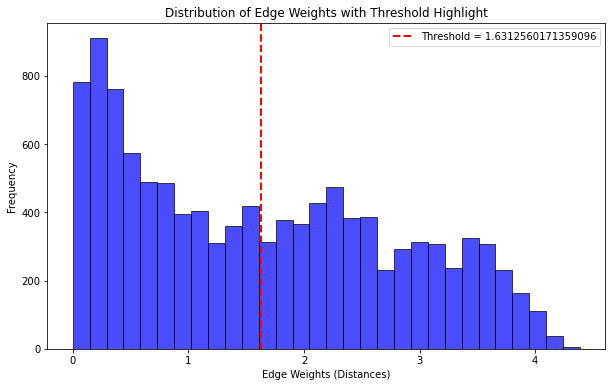

In [11]:
# Get all edge weights & graph threshold
edge_weights = [data['weight'] for _, _, data in H.edges(data=True)]

# Define a threshold for visualization
threshold = np.mean(edge_weights)  # Adjust this value as needed

# Plot the edge weights and highlight the threshold
plt.figure(figsize=(10, 6))
plt.hist(edge_weights, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold = {threshold}')
plt.xlabel('Edge Weights (Distances)')
plt.ylabel('Frequency')
plt.title('Distribution of Edge Weights with Threshold Highlight')
plt.legend()
plt.show()

In [12]:
# Data assignation for node

for i, row in df.iterrows():
    H.nodes[i]['data'] = row  # Assign each row of data as node attribute
print(H.nodes[0])

{'data': Id              -1.720542
SepalLengthCm   -0.900681
SepalWidthCm     1.032057
PetalLengthCm   -1.341272
PetalWidthCm    -1.312977
Species          0.000000
Name: 0, dtype: float64}


## Centrality measure computation


Computation of the two centrality measure

In [13]:
# Computation of the betweennes centrality and closeness centrality 

betweenness_centrality = nx.betweenness_centrality(H, weight='weight')

closeness_centrality = nx.closeness_centrality(H, distance='weight')

#printing results
print("Centralité d'intermédiarité :")
for node, centrality in betweenness_centrality.items():
    print(f"Nœud {node}: {centrality}")

print("\nCentralité de proximité :")
for node, centrality in closeness_centrality.items():
    print(f"Nœud {node}: {centrality}")

Centralité d'intermédiarité :
Nœud 0: 3.0459510790944835
Nœud 1: 1.5973540172627834
Nœud 2: 0.1279492804528477
Nœud 3: 0.6836799455048228
Nœud 4: 0.8318782570522386
Nœud 5: 0.0013806968720477743
Nœud 6: 0.043948642991439656
Nœud 7: 0.35438946623806566
Nœud 8: 0.42838403684260706
Nœud 9: 0.10278200076169465
Nœud 10: 0.1792558452920371
Nœud 11: 0.2879875200485628
Nœud 12: 0.0001256769713145552
Nœud 13: 0.0
Nœud 14: 0.014368623581902886
Nœud 15: 0.044376021829707867
Nœud 16: 4.534736078360239e-05
Nœud 17: 0.017817857302397544
Nœud 18: 0.0011668888692331644
Nœud 19: 0.001977551968652424
Nœud 20: 0.001724475466169259
Nœud 21: 0.017984320316096956
Nœud 22: 0.0
Nœud 23: 0.000739461897180018
Nœud 24: 0.0
Nœud 25: 0.1466382086601312
Nœud 26: 0.0023211726782019315
Nœud 27: 0.08627664130475086
Nœud 28: 0.2160367253616348
Nœud 29: 0.07063511203804008
Nœud 30: 0.02990060388391239
Nœud 31: 0.003931593956844595
Nœud 32: 0.049749546217341456
Nœud 33: 0.10428183680300519
Nœud 34: 0.020626536645898107
N

sorted betweenness
 [(0, 3.0459510790944835), (1, 1.5973540172627834), (4, 0.8318782570522386), (3, 0.6836799455048228), (8, 0.42838403684260706), (7, 0.35438946623806566), (51, 0.3092660556943277), (11, 0.2879875200485628), (28, 0.2160367253616348), (10, 0.1792558452920371), (66, 0.15683071687465716), (25, 0.1466382086601312), (2, 0.1279492804528477), (33, 0.10428183680300519), (9, 0.10278200076169465), (27, 0.08627664130475086), (68, 0.07533741527510811), (29, 0.07063511203804008), (36, 0.06147600343301617), (70, 0.0526315319781318), (32, 0.049749546217341456), (53, 0.048057351911531106), (47, 0.04529128299424896), (15, 0.044376021829707867), (6, 0.043948642991439656), (39, 0.036927524681685746), (78, 0.031886665221712435), (30, 0.02990060388391239), (38, 0.0256426598151182), (126, 0.021477571233409896), (34, 0.020626536645898107), (74, 0.020302087083326058), (123, 0.019984200419436576), (71, 0.019570382881086083), (88, 0.019458810495335113), (101, 0.01922592238916233), (52, 0.018490

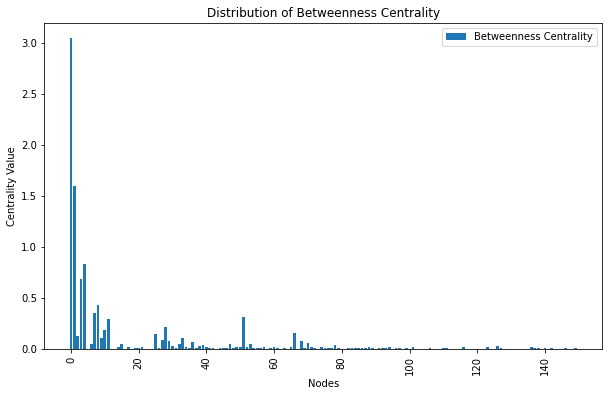

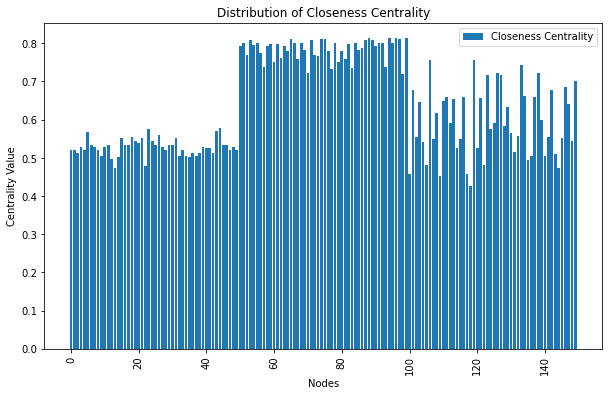

In [14]:
# Sorting values of  betweenness & closeness centrality
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
sorted_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
print("sorted betweenness\n", sorted_betweenness)
print("sorted closeness\n",sorted_closeness)

# Node extraction
nodes_betweenness, values_betweenness = zip(*sorted_betweenness)
nodes_closeness, values_closeness = zip(*sorted_closeness)

# print nodes and values
plt.figure(figsize=(10, 6))
plt.bar(nodes_betweenness, values_betweenness, label='Betweenness Centrality')
plt.xlabel('Nodes')
plt.ylabel('Centrality Value')
plt.title('Distribution of Betweenness Centrality')
plt.xticks(rotation=90)  # Rotate node labels to avoid overlap
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(nodes_closeness, values_closeness, label='Closeness Centrality')
plt.xlabel('Nodes')
plt.ylabel('Centrality Value')
plt.title('Distribution of Closeness Centrality')
plt.xticks(rotation=90)  # Rotate node labels to avoid overlap
plt.legend()
plt.show()

In [15]:
# Calculate the number of nodes to select (top 20%)
num_nodes_betweenness = int(len(betweenness_centrality) * 0.2)
num_nodes_closeness = int(len(closeness_centrality) * 0.2)

# Select top 20% of nodes
top_betweenness_nodes = sorted_betweenness[:num_nodes_betweenness]
top_closeness_nodes = sorted_closeness[:num_nodes_closeness]

# Display the selected nodes
print("Top 20% Nodes based on Betweenness Centrality:")
for node, value in top_betweenness_nodes:
    print(f"Node: {node}, Betweenness Centrality: {value}")

print("\nTop 20% Nodes based on Closeness Centrality:")
for node, value in top_closeness_nodes:
    print(f"Node: {node}, Closeness Centrality: {value}")


Top 20% Nodes based on Betweenness Centrality:
Node: 0, Betweenness Centrality: 3.0459510790944835
Node: 1, Betweenness Centrality: 1.5973540172627834
Node: 4, Betweenness Centrality: 0.8318782570522386
Node: 3, Betweenness Centrality: 0.6836799455048228
Node: 8, Betweenness Centrality: 0.42838403684260706
Node: 7, Betweenness Centrality: 0.35438946623806566
Node: 51, Betweenness Centrality: 0.3092660556943277
Node: 11, Betweenness Centrality: 0.2879875200485628
Node: 28, Betweenness Centrality: 0.2160367253616348
Node: 10, Betweenness Centrality: 0.1792558452920371
Node: 66, Betweenness Centrality: 0.15683071687465716
Node: 25, Betweenness Centrality: 0.1466382086601312
Node: 2, Betweenness Centrality: 0.1279492804528477
Node: 33, Betweenness Centrality: 0.10428183680300519
Node: 9, Betweenness Centrality: 0.10278200076169465
Node: 27, Betweenness Centrality: 0.08627664130475086
Node: 68, Betweenness Centrality: 0.07533741527510811
Node: 29, Betweenness Centrality: 0.07063511203804008

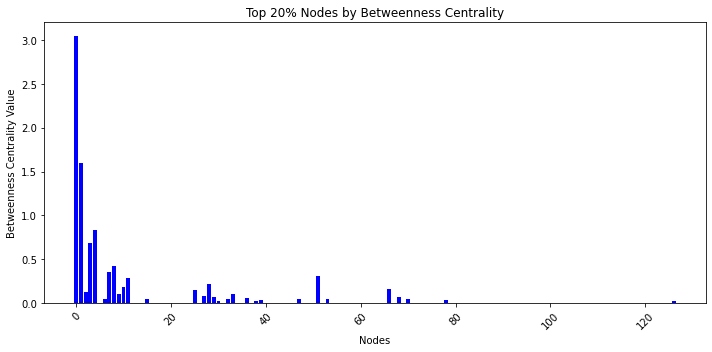

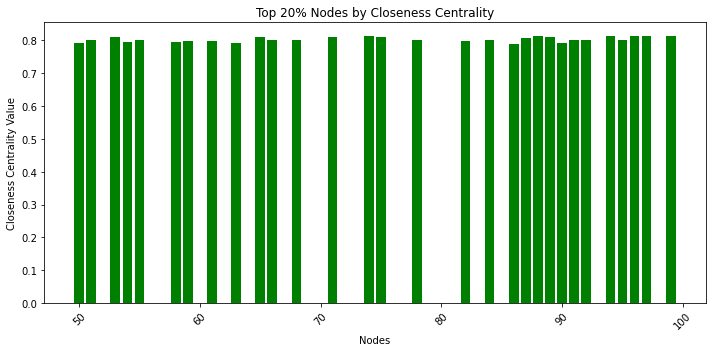

In [16]:
# Betweenness Centrality & Closeness centrality node selection visualization
nodes_betweenness, values_betweenness = zip(*top_betweenness_nodes)
plt.figure(figsize=(10, 5))
plt.bar(nodes_betweenness, values_betweenness, color='blue')
plt.xlabel('Nodes')
plt.ylabel('Betweenness Centrality Value')
plt.title('Top 20% Nodes by Betweenness Centrality')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


nodes_closeness, values_closeness = zip(*top_closeness_nodes)
plt.figure(figsize=(10, 5))
plt.bar(nodes_closeness, values_closeness, color='green')
plt.xlabel('Nodes')
plt.ylabel('Closeness Centrality Value')
plt.title('Top 20% Nodes by Closeness Centrality')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Clustering initialization and searching

The following hierarchical clustering procedure are to be executed wisely depending on which you want to proceed your analysis later on :

In [17]:
#Version CLOSENESS --------------------------------------
node_numbers_closeness = [node for node, closeness in top_closeness_nodes]

def rows_similar(row1, row2, min_matches=2):
    """
    Vérifie si deux lignes partagent au moins `min_matches` valeurs
    identiques parmi les colonnes catégoriques.
    """
    matches = sum(row1[col] == row2[col] for col in categorical_columns)
    return matches >= min_matches

def percolation_clustering(H, threshold):
    clusters = []
    visited_nodes = set()
    
    def can_add_to_cluster(cluster, new_node):
        if not cluster:
            return True
        
        for node in cluster:
            if H.has_edge(new_node, node):
                if H[new_node][node]['weight'] < threshold or not rows_similar(H.nodes[new_node]['data'], H.nodes[node]['data']):
                    return False
        return True
    
    for start_node in node_numbers_closeness:
        
        if start_node not in visited_nodes:
            
            cluster = []
            stack = [start_node]
            
            while stack:
                current_node = stack.pop()
                #print("cnode", current_node)
                if current_node not in visited_nodes:
                    visited_nodes.add(current_node)
                    #print("vnode", visited_nodes)
                    cluster.append(current_node)
                    #print("cluster_constr", cluster)
                    
                    
                    for neighbor in H.neighbors(current_node):
                        if neighbor not in visited_nodes and can_add_to_cluster(cluster, neighbor):
                            stack.append(neighbor)
                
            print("cluster", cluster)
                            
            if cluster:
                clusters.append(cluster)
    
    return clusters

clusters = percolation_clustering(H, threshold)
print(clusters)

total_elements = sum(len(cluster) for cluster in clusters)
print("Nombre d'element totalisé", total_elements)

cluster [94]
cluster [96]
cluster [88]
cluster [99]
cluster [74]
cluster [97]
cluster [65]
cluster [75]
cluster [53]
cluster [71]
cluster [89]
cluster [87]
cluster [55]
cluster [51]
cluster [66]
cluster [68]
cluster [78]
cluster [84]
cluster [95]
cluster [92]
cluster [91]
cluster [61]
cluster [82]
cluster [59]
cluster [54]
cluster [58]
cluster [90]
cluster [50]
cluster [63]
cluster [86]
[[94], [96], [88], [99], [74], [97], [65], [75], [53], [71], [89], [87], [55], [51], [66], [68], [78], [84], [95], [92], [91], [61], [82], [59], [54], [58], [90], [50], [63], [86]]
Nombre d'element totalisé 30


In [18]:
#Version BETWEENES --------------------------------------
node_numbers_betweenness = [node for node, closeness in top_betweenness_nodes]

def rows_similar(row1, row2, min_matches=2):
    """
    Vérifie si deux lignes partagent au moins `min_matches` valeurs
    identiques parmi les colonnes catégoriques.
    """
    matches = sum(row1[col] == row2[col] for col in categorical_columns)
    return matches >= min_matches

def percolation_clustering(H, threshold):
    clusters = []
    visited_nodes = set()
    
    def can_add_to_cluster(cluster, new_node):
        if not cluster:
            return True
        
        for node in cluster:
            if H.has_edge(new_node, node):
                if H[new_node][node]['weight'] < threshold or not rows_similar(H.nodes[new_node]['data'], H.nodes[node]['data']):
                    return False
        return True
    
    for start_node in node_numbers_betweenness:
        
        if start_node not in visited_nodes:
            
            cluster = []
            stack = [start_node]
            
            while stack:
                current_node = stack.pop()
                #print("cnode", current_node)
                if current_node not in visited_nodes:
                    visited_nodes.add(current_node)
                    #print("vnode", visited_nodes)
                    cluster.append(current_node)
                    #print("cluster_constr", cluster)
                    
                    
                    for neighbor in H.neighbors(current_node):
                        if neighbor not in visited_nodes and can_add_to_cluster(cluster, neighbor):
                            stack.append(neighbor)
                
            print("cluster", cluster)
                            
            if cluster:
                clusters.append(cluster)
    
    return clusters

clusters = percolation_clustering(H, threshold)
print(clusters)

total_elements = sum(len(cluster) for cluster in clusters)
print("Nombre d'element totalisé", total_elements)

cluster [0]
cluster [1]
cluster [4]
cluster [3]
cluster [8]
cluster [7]
cluster [51]
cluster [11]
cluster [28]
cluster [10]
cluster [66]
cluster [25]
cluster [2]
cluster [33]
cluster [9]
cluster [27]
cluster [68]
cluster [29]
cluster [36]
cluster [70]
cluster [32]
cluster [53]
cluster [47]
cluster [15]
cluster [6]
cluster [39]
cluster [78]
cluster [30]
cluster [38]
cluster [126]
[[0], [1], [4], [3], [8], [7], [51], [11], [28], [10], [66], [25], [2], [33], [9], [27], [68], [29], [36], [70], [32], [53], [47], [15], [6], [39], [78], [30], [38], [126]]
Nombre d'element totalisé 30


In [19]:
# Version CLOSENESS MERGED --------------------------------------
node_numbers_closeness = [node for node, closeness in top_closeness_nodes]

def rows_similar(row1, row2, min_matches=2):
    """
    Vérifie si deux lignes partagent au moins `min_matches` valeurs
    identiques parmi les colonnes catégoriques.
    """
    matches = sum(row1[col] == row2[col] for col in categorical_columns)
    return matches >= min_matches

def can_add_to_cluster(cluster, new_node, H, threshold):
    if not cluster:
        return True
    
    for node in cluster:
        if H.has_edge(new_node, node):
            if H[new_node][node]['weight'] < threshold or not rows_similar(H.nodes[new_node]['data'], H.nodes[node]['data']):
                return False
    return True

def percolation_clustering(H, threshold):
    clusters = []
    
    for start_node in node_numbers_closeness:
        cluster = []
        stack = [start_node]
        
        while stack:
            current_node = stack.pop()
            if current_node not in cluster:  # Node can participate in multiple clusters
                cluster.append(current_node)
                
                for neighbor in H.neighbors(current_node):
                    if can_add_to_cluster(cluster, neighbor, H, threshold):
                        stack.append(neighbor)
        
        print("Initial cluster formed", cluster)
        
        if cluster:
            clusters.append(cluster)
    
    return clusters

def merge_clusters(clusters, H, threshold, overlap_threshold):
    """
    Merge clusters based on node overlap and similarity.

    Parameters:
    clusters (list of lists): List of clusters where each cluster is a list of nodes.
    H (networkx.Graph): A NetworkX graph where edges have a 'weight' attribute representing similarity.
    threshold (float): The similarity threshold for merging clusters.
    overlap_threshold (float): The minimum overlap required for merging two clusters.

    Returns:
    list of lists: The new list of merged clusters.
    """
    merged_clusters = []
    used_clusters = set()
    
    def calculate_overlap(cluster1, cluster2):
        return len(set(cluster1).intersection(set(cluster2)))

    def can_merge_clusters(cluster1, cluster2, H, threshold, overlap_threshold):
        """
        Determine if two clusters can be merged based on node overlap and similarity.
        """
        overlap = calculate_overlap(cluster1, cluster2)
        if overlap / min(len(cluster1), len(cluster2)) < overlap_threshold:
            return False
        
        # Compute the average similarity between nodes in the overlap
        similarities = []
        for node1 in cluster1:
            for node2 in cluster2:
                if H.has_edge(node1, node2):
                    similarities.append(H[node1][node2].get('weight', 0))
        
        if len(similarities) == 0:
            return False
        
        average_similarity = np.mean(similarities)
        return average_similarity >= threshold

    for i in range(len(clusters)):
        if i in used_clusters:
            continue
        
        merged_cluster = set(clusters[i])
        
        for j in range(i + 1, len(clusters)):
            if j in used_clusters:
                continue
            
            if can_merge_clusters(merged_cluster, clusters[j], H, threshold, overlap_threshold):
                merged_cluster.update(clusters[j])
                used_clusters.add(j)
        
        merged_clusters.append(list(merged_cluster))
        used_clusters.add(i)
    
    return merged_clusters

clusters = percolation_clustering(H, threshold)
print("Initial clusters:", clusters)

# Experiment with different overlap thresholds
overlap_threshold = 1
print(f"Testing overlap threshold: {overlap_threshold}")
merged_clusters = merge_clusters(clusters, H, threshold, overlap_threshold)
print("Merged clusters:", merged_clusters)
total_elements = sum(len(cluster) for cluster in merged_clusters)
print("Total elements after merging", total_elements)

total_elements = sum(len(cluster) for cluster in merged_clusters)
print("Total elements after merging", total_elements)

Initial cluster formed [94]
Initial cluster formed [96]
Initial cluster formed [88]
Initial cluster formed [99]
Initial cluster formed [74]
Initial cluster formed [97]
Initial cluster formed [65]
Initial cluster formed [75]
Initial cluster formed [53]
Initial cluster formed [71]
Initial cluster formed [89]
Initial cluster formed [87]
Initial cluster formed [55]
Initial cluster formed [51]
Initial cluster formed [66]
Initial cluster formed [68]
Initial cluster formed [78]
Initial cluster formed [84]
Initial cluster formed [95]
Initial cluster formed [92]
Initial cluster formed [91]
Initial cluster formed [61]
Initial cluster formed [82]
Initial cluster formed [59]
Initial cluster formed [54]
Initial cluster formed [58]
Initial cluster formed [90]
Initial cluster formed [50]
Initial cluster formed [63]
Initial cluster formed [86]
Initial clusters: [[94], [96], [88], [99], [74], [97], [65], [75], [53], [71], [89], [87], [55], [51], [66], [68], [78], [84], [95], [92], [91], [61], [82], [59

In [20]:
# Version BETWEENNESS MERGED --------------------------------------
node_numbers_betweenness = [node for node, betweenness in top_betweenness_nodes]

def rows_similar(row1, row2, min_matches=2):
    """
    Vérifie si deux lignes partagent au moins `min_matches` valeurs
    identiques parmi les colonnes catégoriques.
    """
    matches = sum(row1[col] == row2[col] for col in categorical_columns)
    return matches >= min_matches

def can_add_to_cluster(cluster, new_node, H, threshold):
    if not cluster:
        return True
    
    for node in cluster:
        if H.has_edge(new_node, node):
            if H[new_node][node]['weight'] < threshold or not rows_similar(H.nodes[new_node]['data'], H.nodes[node]['data']):
                return False
    return True

def percolation_clustering(H, threshold):
    clusters = []
    
    for start_node in node_numbers_betweenness:
        cluster = []
        stack = [start_node]
        
        while stack:
            current_node = stack.pop()
            if current_node not in cluster:  # Node can participate in multiple clusters
                cluster.append(current_node)
                
                for neighbor in H.neighbors(current_node):
                    if can_add_to_cluster(cluster, neighbor, H, threshold):
                        stack.append(neighbor)
        
        print("Initial cluster formed", cluster)
        
        if cluster:
            clusters.append(cluster)
    
    return clusters

def merge_clusters(clusters, H, threshold):
    merged_clusters = []
    used_clusters = set()
    
    for i in range(len(clusters)):
        if i in used_clusters:
            continue
        
        merged_cluster = set(clusters[i])
        
        for j in range(i + 1, len(clusters)):
            if j in used_clusters:
                continue
            
            intersection = merged_cluster.intersection(clusters[j])
            if intersection:
                # Check if clusters can be merged based on intersection and similarity
                merged = True
                for node in intersection:
                    if not can_add_to_cluster(merged_cluster, node, H, threshold):
                        merged = False
                        break
                
                if merged:
                    merged_cluster.update(clusters[j])
                    used_clusters.add(j)
        
        merged_clusters.append(list(merged_cluster))
        used_clusters.add(i)
    
    return merged_clusters

clusters = percolation_clustering(H, threshold)
print("Initial clusters:", clusters)

# Apply cluster merging based on coverage
merged_clusters = merge_clusters(clusters, H, threshold)
print("Merged clusters:", merged_clusters)

total_elements = sum(len(cluster) for cluster in merged_clusters)
print("Total elements after merging", total_elements)


Initial cluster formed [0]
Initial cluster formed [1]
Initial cluster formed [4]
Initial cluster formed [3]
Initial cluster formed [8]
Initial cluster formed [7]
Initial cluster formed [51]
Initial cluster formed [11]
Initial cluster formed [28]
Initial cluster formed [10]
Initial cluster formed [66]
Initial cluster formed [25]
Initial cluster formed [2]
Initial cluster formed [33]
Initial cluster formed [9]
Initial cluster formed [27]
Initial cluster formed [68]
Initial cluster formed [29]
Initial cluster formed [36]
Initial cluster formed [70]
Initial cluster formed [32]
Initial cluster formed [53]
Initial cluster formed [47]
Initial cluster formed [15]
Initial cluster formed [6]
Initial cluster formed [39]
Initial cluster formed [78]
Initial cluster formed [30]
Initial cluster formed [38]
Initial cluster formed [126]
Initial clusters: [[0], [1], [4], [3], [8], [7], [51], [11], [28], [10], [66], [25], [2], [33], [9], [27], [68], [29], [36], [70], [32], [53], [47], [15], [6], [39], [7

## Dendogramme visualization and metrics

For Merged_Clusters : 

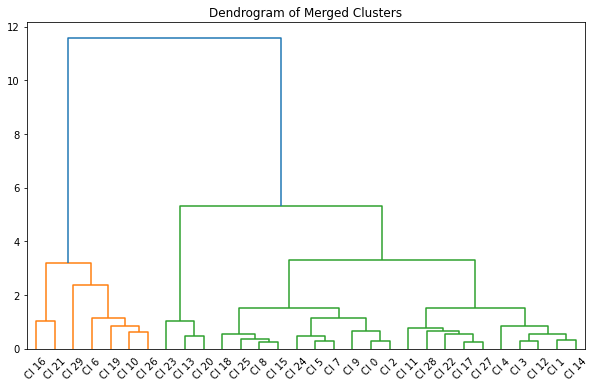

In [21]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score
)
import matplotlib.pyplot as plt

def clusters_to_data(clusters, data):
    """Return a DataFrame of cluster‐centroids (numeric cols only)."""
    num_cols = data.select_dtypes(include=[np.number]).columns
    rows = []
    for cluster in clusters:
        dfc = data.iloc[cluster]
        rows.append(dfc[num_cols].mean().values)
    return pd.DataFrame(rows, columns=num_cols)

def dunn_index(X, labels):
    """Simple Dunn Index on X (array‐like) with integer labels."""
    unique = np.unique(labels)
    k = unique.size
    D = squareform(pdist(X))
    # max intra‐cluster distance
    intra = np.zeros(k)
    for i,lab in enumerate(unique):
        pts = D[np.ix_(labels==lab, labels==lab)]
        intra[i] = pts.max() if pts.size>1 else 0
    # min inter‐cluster distance
    inter = np.full((k,k), np.inf)
    for i in range(k):
        for j in range(i+1,k):
            a = X[labels==unique[i]]
            b = X[labels==unique[j]]
            inter[i,j] = pdist(np.vstack([a,b])).min()
    min_inter = inter[inter< np.inf].min()
    max_intra = intra.max()
    return 0 if max_intra==0 else min_inter/max_intra

# ————————————————————————————————————————————————————————————————

# suppose merged_clusters is your list-of-lists of row‐indices
cluster_data = clusters_to_data(merged_clusters, df)

# 1) Hierarchical linkage on centroids
Z = linkage(cluster_data, method="ward")

# 2) Make a flat label array for every original row in all clusters
labels = np.concatenate([[i]*len(c) for i,c in enumerate(merged_clusters)])
flat_idx = np.concatenate(merged_clusters)
flat_data = df.iloc[flat_idx].select_dtypes(include=[np.number]).values

# 3) Now check how many clusters have >1 point
counts = np.bincount(labels)
multi_pts = np.where(counts>1)[0]

if multi_pts.size >= 2:
    # mask to keep only points belonging to clusters of size >1
    mask = np.isin(labels, multi_pts)
    X_good = flat_data[mask]
    y_good = labels[mask]

    sil = silhouette_score(X_good, y_good)
    db  = davies_bouldin_score(X_good, y_good)
    dunn = dunn_index(X_good, y_good)
    coph, _ = cophenet(Z, pdist(cluster_data))

    print(f"Silhouette Coeff : {sil:.3f}")
    print(f"Davies–Bouldin  : {db:.3f}")
    print(f"Dunn Index      : {dunn:.3f}")
    print(f"Cophenetic Corr.: {coph:.3f}")

else:
    print("Warning: not enough multi‐point clusters: cannot compute Silhouette/Dunn/DB.")

# 4) Always OK to plot the dendrogram of the centroids
plt.figure(figsize=(10,6))
dendrogram(Z, labels=[f"Cl {i}" for i in range(len(cluster_data))])
plt.title("Dendrogram of Merged Clusters")
plt.show()


For Non-Merged_Clusters : 

Skipping Silhouette & Davies–Bouldin: need ≥2 clusters of size>1.
Dunn Index:             0.000
Cophenetic Correlation: 0.919


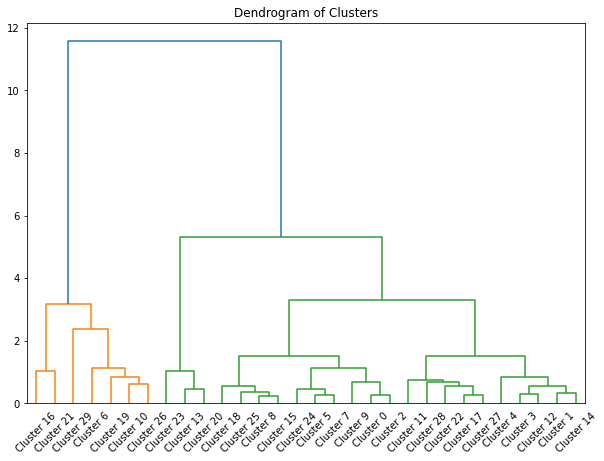

In [22]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

def clusters_to_data(clusters, data):
    num_cols = data.select_dtypes(include=[np.number]).columns
    rows = []
    for c in clusters:
        dfc = data.iloc[c]
        rows.append(dfc[num_cols].mean().values)
    return pd.DataFrame(rows, columns=num_cols)

def dunn_index(X, labels):
    unique = np.unique(labels)
    k = unique.size
    D = squareform(pdist(X))
    intra = np.zeros(k)
    for i,lab in enumerate(unique):
        sub = D[np.ix_(labels==lab, labels==lab)]
        intra[i] = sub.max() if sub.size>1 else 0
    inter = np.full((k,k), np.inf)
    for i in range(k):
        for j in range(i+1,k):
            a = X[labels==unique[i]]
            b = X[labels==unique[j]]
            inter[i,j] = pdist(np.vstack([a,b])).min()
    min_inter = inter[inter<np.inf].min()
    max_intra = intra.max()
    return 0 if max_intra==0 else min_inter/max_intra

# —————————————————————————————————————————————————————

# 1) Centroids and linkage
cluster_data = clusters_to_data(clusters, df)
Z = linkage(cluster_data, method='ward')

# 2) Flatten data & labels
flat_idx = np.concatenate(clusters)
X_full   = df.select_dtypes(include=[np.number]).iloc[flat_idx].values
labels   = np.concatenate([[i]*len(c) for i,c in enumerate(clusters)])
n_samples = X_full.shape[0]

# 3) Identify non‐singleton clusters
uniq, counts = np.unique(labels, return_counts=True)
good_labels = uniq[counts > 1]
mask = np.isin(labels, good_labels)

if len(good_labels) >= 2:
    Xg = X_full[mask]
    yg = labels[mask]
    # now 2 ≤ n_clusters < n_samples holds
    sil = silhouette_score(Xg, yg)
    db  = davies_bouldin_score(Xg, yg)
    print(f"Silhouette Coefficient: {sil:.3f}")
    print(f"Davies–Bouldin Index:   {db:.3f}")
else:
    print("Skipping Silhouette & Davies–Bouldin: need ≥2 clusters of size>1.")

# 4) Dunn Index on full set (handles singletons)
dunn = dunn_index(X_full, labels)
print(f"Dunn Index:             {dunn:.3f}")

# 5) Cophenetic Correlation on centroids
coph, _ = cophenet(Z, pdist(cluster_data))
print(f"Cophenetic Correlation: {coph:.3f}")

# 6) Dendrogram
plt.figure(figsize=(10,7))
dendrogram(Z, labels=[f'Cluster {i}' for i in range(len(cluster_data))])
plt.title("Dendrogram of Clusters")
plt.show()


## Graph and some data visualization

Visualization of the hyper Graph :

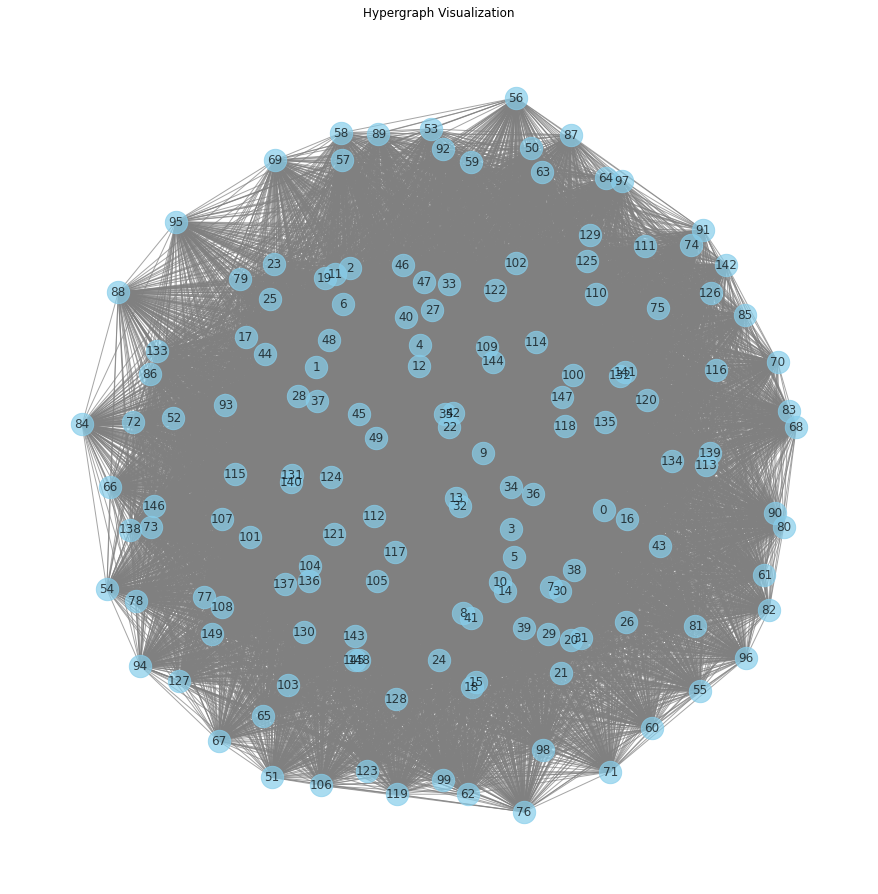

In [23]:
# Visualization of the hypergraph
pos = nx.spring_layout(H)  # Position nodes using Fruchterman-Reingold force-directed algorithm
plt.figure(figsize=(12, 12))
nx.draw(H, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, alpha=0.7)
plt.title('Hypergraph Visualization')
plt.show()

Correlation Matrix of the data

#Step-by-step structure

In [24]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
import networkx as nx
import gower                                # ← new
from scipy.cluster.hierarchy import linkage, cophenet
from scipy.spatial.distance    import pdist, cdist
from sklearn.metrics          import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)

# ----------------------------------------------------------------
# Helper #2: build threshold graph
def build_graph_from_dist(D, thr):
    G = nx.Graph()
    n = D.shape[0]
    G.add_nodes_from(range(n))
    for i in range(n):
        for j in range(i+1, n):
            if D[i,j] <= thr:
                G.add_edge(i, j, weight=D[i,j])
    return G

# ----------------------------------------------------------------
# Helper #3: percolation clusters via connected components around seeds
def percolation_clusters(G, seeds):
    clusters = []; seen = set()
    for s in seeds:
        if s in seen: continue
        comp = set(nx.node_connected_component(G, s))
        clusters.append(list(comp))
        seen |= comp
    return clusters

# ----------------------------------------------------------------
# Helper #4: Dunn index
def dunn_index(X, labels):
    labs = np.array(labels)
    uniq = [c for c in np.unique(labs) if c>=0]
    if len(uniq) < 2: return np.nan
    # intra‐cluster diameters
    max_diams = []
    for c in uniq:
        pts = X[labs==c]
        max_diams.append(np.max(pdist(pts)) if len(pts)>1 else 0.0)
    max_d = np.max(max_diams)
    # inter‐cluster min distance
    min_inter = np.inf
    for i,c1 in enumerate(uniq):
        for c2 in uniq[i+1:]:
            pts1 = X[labs==c1]; pts2 = X[labs==c2]
            d12 = np.min(cdist(pts1, pts2))
            min_inter = min(min_inter, d12)
    return (min_inter / max_d) if max_d>0 else np.nan

# ----------------------------------------------------------------
def merge_clusters(clusters, ov_thr):
    merged = True
    while merged and len(clusters)>1:
        merged = False
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                A, B = set(clusters[i]), set(clusters[j])
                overlap = len(A & B)/min(len(A), len(B))
                if overlap >= ov_thr:
                    clusters[i] = list(A|B)
                    del clusters[j]
                    merged = True
                    break
            if merged: break
    return clusters

def flatten_labels(n_samples, clusters):
    labels = np.full(n_samples, -1, dtype=int)
    for cid, c in enumerate(clusters):
        for idx in c:
            labels[idx] = cid
    return labels

def parameter_sweep(df, D, perc_seed=0.2, n_thr=10, ov_thr_list=None):
    n = len(df)
    dvals = D[np.triu_indices(n,1)]
    pctiles = np.linspace(5,95,n_thr)
    thr_range = np.percentile(dvals, pctiles)
    if ov_thr_list is None:
        ov_thr_list = np.linspace(0.1,0.9,9)

    results = []
    for thr in thr_range:
        G = build_graph_from_dist(D, thr)
        bc = nx.betweenness_centrality(G, weight='weight')
        n_seeds = max(1, int(len(bc)*perc_seed))
        seeds = sorted(bc, key=bc.get, reverse=True)[:n_seeds]
        raw = percolation_clusters(G, seeds)

        for ov_thr in ov_thr_list:
            clusters = merge_clusters([c.copy() for c in raw], ov_thr)
            if len(clusters) < 2:
                continue

            labels = flatten_labels(n, clusters)
            valid = len(set(labels))>1

            sil    = silhouette_score(df, labels)                                         if valid else np.nan
            sil_gw = silhouette_score(D,  labels, metric='precomputed')                   if valid else np.nan
            dunn   = dunn_index(df.values, labels)
            db     = davies_bouldin_score(df, labels)                                     if valid else np.nan
            ch     = calinski_harabasz_score(df, labels)                                  if valid else np.nan

            centroids = np.vstack([df.iloc[c].mean(axis=0).values for c in clusters])
            if centroids.shape[0]>=2 and np.ptp(centroids, axis=0).any():
                with np.errstate(divide='ignore', invalid='ignore'):
                    Z, _ = linkage(centroids, method='ward'), pdist(centroids)
                    coph  = cophenet(Z, _)[0]
            else:
                coph = np.nan

            results.append({
                'thr': thr,
                'ov_thr': ov_thr,
                'n_clusters': len(clusters),
                'silhouette': sil,
                'silhouette_gower': sil_gw,
                'dunn': dunn,
                'db_index': db,
                'calinski_harabasz': ch,
                'cophenet': coph
            })

    return pd.DataFrame(results)


if __name__ == "__main__":
    # 2) Define which are categorical vs numeric
    cats = categorical_columns
    nums = numerical_columns

    # 3) Encode & scale
    from sklearn.preprocessing import LabelEncoder, StandardScaler
    for c in cats:
        df[c] = LabelEncoder().fit_transform(df[c].astype(str))
    df[nums] = StandardScaler().fit_transform(df[nums])
    df_proc = df[cats + nums]

    # 4) Gower distance via gower.gower_matrix
    D = gower.gower_matrix(df_proc)

    # 5) Sweep
    results_df = parameter_sweep(
        df_proc, D,
        perc_seed=0.2,
        n_thr=20,
        ov_thr_list=np.linspace(0.1,0.9,9)
    )

    # 6) Save & report summary
    results_df.to_csv("sweep_results.csv", index=False)

    print("\n=== Top 10 by Silhouette (high→low) ===")
    print(results_df.sort_values("silhouette", ascending=False).head(10))
    print("\n=== Top 10 by Silhouette (Gower, high→low) ===")
    print(results_df.sort_values("silhouette_gower", ascending=False).head(10))
    print("\n=== Top 10 by Calinski–Harabasz (high→low) ===")
    print(results_df.sort_values("calinski_harabasz", ascending=False).head(10))
    print("\n=== Top 10 by Dunn Index (high→low) ===")
    print(results_df.sort_values("dunn", ascending=False).head(10))
    print("\n=== Top 10 by Davies–Bouldin (low→high) ===")
    print(results_df.sort_values("db_index", ascending=True).head(10))
    print("\n=== Top 10 by Cophenetic Corr (high→low) ===")
    print(results_df.sort_values("cophenet", ascending=False).head(10))

    # 7) Final evaluation on best‐by‐Silhouette
    best      = results_df.sort_values('silhouette', ascending=False).iloc[0]
    thr_opt   = best['thr']
    ov_thr_opt= best['ov_thr']
    print(f"\n>> Re-evaluating at thr={thr_opt:.3f}, ov_thr={ov_thr_opt:.2f}\n")

    G = build_graph_from_dist(D, thr_opt)
    bc = nx.betweenness_centrality(G, weight='weight')
    seeds = sorted(bc, key=bc.get, reverse=True)[:max(1,int(len(bc)*0.2))]
    raw = percolation_clusters(G, seeds)
    clusters = merge_clusters([c.copy() for c in raw], ov_thr_opt)
    labels   = flatten_labels(len(df_proc), clusters)
    X        = df_proc.values
    valid    = len(set(labels))>1

    sil_f     = silhouette_score(X, labels)                         if valid else np.nan
    sil_gw_f  = silhouette_score(D, labels, metric='precomputed')   if valid else np.nan
    ch_f      = calinski_harabasz_score(X, labels)                  if valid else np.nan
    dunn_f    = dunn_index(X, labels)
    db_f      = davies_bouldin_score(X, labels)                     if valid else np.nan

    centroids = np.vstack([df_proc.iloc[c].mean(axis=0).values for c in clusters])
    if centroids.shape[0]>=2 and np.ptp(centroids, axis=0).any():
        with np.errstate(divide='ignore', invalid='ignore'):
            Zf, _    = linkage(centroids, method='ward'), pdist(centroids)
            coph_f,_ = cophenet(Zf, _)
    else:
        coph_f = np.nan

    print(f"Silhouette Coefficient:            {sil_f:.3f}")
    print(f"Silhouette (Gower):                {sil_gw_f:.3f}")
    print(f"Calinski–Harabasz Index:           {ch_f:.3f}")
    print(f"Dunn Index:                        {dunn_f:.3f}")
    print(f"Davies–Bouldin Index:              {db_f:.3f}")
    print(f"Cophenetic Corr. Coef (CCC):       {coph_f:.3f}")


D:\anaconda3\lib\site-packages\pandas\core\indexes\base.py:7900: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)



=== Top 10 by Silhouette (high→low) ===
         thr  ov_thr  n_clusters  silhouette  silhouette_gower      dunn  \
62  0.202894     0.9           2     0.57841          0.666705  0.306987   
53  0.154190     0.9           2     0.57841          0.666705  0.306987   
45  0.154190     0.1           2     0.57841          0.666705  0.306987   
46  0.154190     0.2           2     0.57841          0.666705  0.306987   
47  0.154190     0.3           2     0.57841          0.666705  0.306987   
49  0.154190     0.5           2     0.57841          0.666705  0.306987   
50  0.154190     0.6           2     0.57841          0.666705  0.306987   
51  0.154190     0.7           2     0.57841          0.666705  0.306987   
52  0.154190     0.8           2     0.57841          0.666705  0.306987   
48  0.154190     0.4           2     0.57841          0.666705  0.306987   

    db_index  calinski_harabasz  cophenet  
62  0.586755         273.119496       NaN  
53  0.586755         273.119496   

Compare with other 

In [25]:
# ----------------------------------------------------------------
# Mixed‐data clustering comparison (uses df, numerical_columns, categorical_columns, n_cluster_opt)
# ----------------------------------------------------------------
import gower                                 # pip install gower
from sklearn.impute       import SimpleImputer
from sklearn.metrics      import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.cluster      import (
    AgglomerativeClustering,
    DBSCAN,
    SpectralClustering,
    AffinityPropagation
)
from sklearn_extra.cluster import KMedoids  # pip install scikit-learn-extra
from kmodes.kprototypes  import KPrototypes # pip install kmodes
from scipy.spatial.distance import cdist
import numpy as np
from sklearn.cluster import OPTICS

# shorthand
num_cols = numerical_columns
cat_cols = categorical_columns
n_clusters = n_cluster_opt

# 1) Impute numerics & categoricals
imp_num = SimpleImputer(strategy='mean')
imp_cat = SimpleImputer(strategy='most_frequent')

df_num = pd.DataFrame(
    imp_num.fit_transform(df[num_cols]),
    columns=num_cols, index=df.index
)
df_cat = pd.DataFrame(
    imp_cat.fit_transform(df[cat_cols]),
    columns=cat_cols, index=df.index
)
df_imputed = pd.concat([df_num, df_cat], axis=1)

# 2) Prepare vector version (for Euclidean‐based metrics)
df_proc = df_imputed.copy()
for c in cat_cols:
    df_proc[c] = df_proc[c].astype('category').cat.codes
X_vec = df_proc.values

# 3) Distance matrices
D_gower  = gower.gower_matrix(df_imputed)               # full N×N
D_euc_sq = cdist(X_vec, X_vec, metric='euclidean')      # for Dunn

# 4) Helpers
def dunn_index(X_dist, labels):
    labels = np.array(labels)
    clus = np.unique(labels[labels>=0])
    if len(clus)<2:
        return np.nan
    # inter‐cluster min
    delta = np.inf
    for i in clus:
        for j in clus:
            if i<j:
                dij = X_dist[np.ix_(labels==i, labels==j)].min()
                delta = min(delta, dij)
    # intra‐cluster max diameter
    diam = 0.0
    for i in clus:
        mat = X_dist[np.ix_(labels==i, labels==i)]
        if mat.size>1:
            diam = max(diam, mat.max())
    return delta/diam if diam>0 else np.nan

results = {}
def evaluate(name, labels):
    labels = np.array(labels)
    real = np.unique(labels[labels>=0])
    if len(real)<2:
        results[name] = (np.nan,)*5
        return
    try:
        sil_e = silhouette_score(X_vec, labels, metric='euclidean')
        sil_g = silhouette_score(D_gower, labels, metric='precomputed')
        ch    = calinski_harabasz_score(X_vec, labels)
        db    = davies_bouldin_score(X_vec, labels)
        di    = dunn_index(D_euc_sq, labels)
    except:
        sil_e = sil_g = ch = db = di = np.nan
    results[name] = (sil_e, sil_g, ch, di, db)

# 5) Run methods
# 5.1) Agglomerative (Gower)
labels_agg = AgglomerativeClustering(
    n_clusters=n_clusters, metric='precomputed', linkage='average'
).fit_predict(D_gower)
evaluate("Agglomerative", labels_agg)

# 5.2) K-Medoids (Gower)
labels_km = KMedoids(
    n_clusters=n_clusters, metric='precomputed',
    init='k-medoids++', random_state=0
).fit_predict(D_gower)
evaluate("K-Medoids", labels_km)

# 5.3) AffinityPropagation (Gower)
#    builds clusters around “exemplars” without density assumptions
from sklearn.cluster import AffinityPropagation

# convert distances to similarities (D_gower ∈ [0,1])
S = 1.0 - D_gower
np.fill_diagonal(S, 1.0)

ap = AffinityPropagation(
    affinity='precomputed',
    random_state=0,
    # preference=None   # you can set this to bias toward more/fewer clusters
)
labels_ap = ap.fit_predict(S)
evaluate("AffinityProp", labels_ap)

# 5.5) SpectralClustering (Gower)
labels_sp = SpectralClustering(
    n_clusters=n_clusters, affinity='precomputed',
    assign_labels='kmeans', random_state=0
).fit_predict(D_gower)
evaluate("Spectral", labels_sp)

# 5.6) K-Prototypes (mixed)
cat_idx   = [df_proc.columns.get_loc(c) for c in cat_cols]
labels_kp = KPrototypes(
    n_clusters=n_clusters, init='Huang',
    n_init=5, random_state=0
).fit_predict(X_vec, categorical=cat_idx)
evaluate("K-Prototypes", labels_kp)

# 6) Report
print(f"{'Method':15s} {'Sil(Euc)':>8s} {'Sil(Gow)':>8s} {'CH':>8s} {'Dunn':>8s} {'DB':>8s}")
print("-"*60)
for m,(se,sg,ch,di,db) in results.items():
    print(f"{m:15s} {se:8.3f} {sg:8.3f} {ch:8.1f} {di:8.3f} {db:8.3f}")


D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Method          Sil(Euc) Sil(Gow)       CH     Dunn       DB
------------------------------------------------------------
Agglomerative      0.488    0.675    265.0    0.230    0.844
K-Medoids          0.488    0.675    265.0    0.230    0.844
AffinityProp       0.286    0.280    172.9    0.056    1.136
Spectral           0.048    0.069     12.4    0.010    2.699
K-Prototypes       0.491    0.650    271.2    0.117    0.831
